In [1]:
import networkx as nx
import numpy as np
import numpy as np
import numpy.linalg as la
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

In [296]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Implementing Higher order Markov chains

In [2]:
matX = np.loadtxt('C:/Users/rohil/Downloads/Uni Bonn/SoSe 2020/GAME AI/Practical Problems/q3dm1-path2.csv', delimiter=',')
matX = matX.T
matV = np.empty(shape = (matX.shape[0],matX.shape[1]-1))

In [3]:
#Find velocities or action states
for i in range(matX.shape[0]):
    for j in range(matX.shape[1]-1):
        matV[i,j] = matX[i,j+1] - matX[i,j]

#Find representative actions using kmeans on velocity matrix - i.e find k_A action primitives 
import scipy.cluster.vq as vq
matA, inds = vq.kmeans2(matV.T, k=36, iter=10000, minit='++')

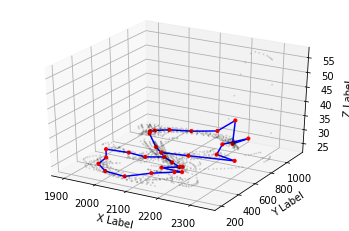

In [4]:
# DOUBLE RING SOM

def DoubleRing(matX, k):
    matX= np.transpose(matX)
    G1 = nx.generators.lattice.grid_2d_graph(k//2, 1, periodic = True)
    G2 = nx.generators.lattice.grid_2d_graph(k//2, 1, periodic = True)
    G = nx.disjoint_union(G1,G2)
    G.add_edge(0,k-1)
    G = nx.convert_node_labels_to_integers(G)
    m, n = matX.shape
    smpl = rnd.choice(n, k, replace=False)
    for i, v in enumerate(G):
        G.node[v]['w'] = matX[:,smpl[i]]
    return G

def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1.):
    m, n = matX.shape
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    # because this allows for easy squaring of its entries
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, n, size=tmax)
    for t in range(tmax):
        # sample a point x, i.e. a column of matrix X
        vecX = matX[:,smpl[t]]
        # determine the best matching unit
        b = np.argmin([np.sum((G.node[v]['w'] - vecX)**2) for v in G])
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        # update all weights
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            G.node[v]['w'] += eta * h * (vecX - G.node[v]['w'])
    return G

# Finding k_S = 20 states

k = 30
SOM2 = DoubleRing(matX.T, k)
SOM2 = trainSOM(matX, SOM2, tmax=10000)

graph_som = np.zeros(shape = (k,3))
for i,v in enumerate(SOM2):
    graph_som[v] = SOM2.node[v]['w']
graph_som = graph_som.T

#matX = matX.T
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(matX[1],matX[0],matX[2], c='black', marker='o', s=1, alpha = 0.1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label') 

ax.scatter3D(graph_som[1],graph_som[0],graph_som[2], c='red', marker='o', s=10, alpha = 1)

for i in SOM2.edges:
    x,y = i
    ax.plot3D([graph_som[1,x],graph_som[1,y]],[graph_som[0,x],graph_som[0,y]],[graph_som[2,x],graph_som[2,y]],"blue")
    

In [5]:
#MAPPING ACTION PRIMITIVES TO ORIGINAL VELOCITY VECTOR
tmax = matV.shape[1]
inds_check = np.empty(shape = matV.shape[1])
for t in range(tmax):
    vecX = matV.T[t]
    b = np.argmin([np.sum((action_prim - vecX)**2) for action_prim in matA])
    inds_check[t] = b
    
set(inds - inds_check)  #CHECKS IF inds returned by scipy maps the action primitives correctly.

#MAPPING SOM_WEIGHTS TO ORIGINAL DATA TO OBTAIN STATES
tmax = matX.shape[1]
Xstate = np.empty(shape = matX.shape[1])
for t in range(tmax):
    vecX = matX.T[t]
    b = np.argmin([np.sum((state - vecX)**2) for state in graph_som.T])
    Xstate[t] = b
    
def estimateTensorProbability(state_indices, primitives):
    P = np.zeros(shape=(len(set(primitives)),len(set(state_indices)),len(set(primitives))))
    for t in range(0, primitives.shape[0]):
        P[int(primitives[t]),int(state_indices[t]),int(primitives[t-1])] += 1.
    return P/np.sum(P)

def estimateProbability(state_indices, primitives):
    P = np.zeros((len(set(state_indices)),len(set(primitives))))
    for t in range(0, primitives.shape[0]):
        P[int(state_indices[t]),int(primitives[t])] += 1.
    return P/np.sum(P)

Pjoint3D = estimateTensorProbability(Xstate,inds)
Pjoint2D = estimateProbability(Xstate,inds)
print(np.sum(Pjoint2D))

1.0


In [6]:
np.sum(Pjoint2D,axis = 0).shape

(36,)

In [7]:
# Getting the prior probabilities for States and Actions

Pstates = np.sum(Pjoint2D,axis = 1) #Prior probabilities of States
Pactions = np.sum(Pjoint2D, axis = 0) #Prior probabilities of Actions

#Obtain Summation values for marginalization

Sliced_summations = np.empty(shape = (Pjoint3D.shape[0],Pjoint3D.shape[1]))
for i in range(Pjoint3D.shape[0]):
    for j in range(Pjoint3D.shape[1]):
        if np.sum(Pjoint3D[i][j]) == 0:
            for k in range(Pjoint3D.shape[2]):
                Pjoint3D[i][j][k] = Pjoint3D[i][j][k] + 0.000000000000000001 # Epsilon added TO FACTOR FOR ZERO PROB
        Sliced_summations[i][j] = np.sum(Pjoint3D[i][j]) 
    
np.sum(Sliced_summations) #Check


1.0000000000000289

In [9]:
# Getting the conditional matrix P[A | S,A[t-1]]

Pconditional = np.copy(Pjoint3D)

for i in range(Pjoint3D.shape[0]):
    for j in range(Pjoint3D.shape[1]):
        for k in range(Pjoint3D.shape[2]):
            Pconditional[i][j][k] = Pconditional[i][j][k]/Sliced_summations[i][j] 
np.sum(Pconditional)
Pconditional.shape

(36, 30, 36)

In [305]:
tmax = 1288
#tmax = matX.shape[1]
X_hat = np.zeros(shape = (3, tmax))
X_hat[:,0] = matX[:,0]  #Intitialize random state

a_hat = np.zeros(shape = (tmax,1))
a_hat[0] = inds[0]

eta = 0.8

for t in range(1,tmax):
    vecX = matX.T[t-1]
    b = np.argmin([np.sum((state - vecX)**2) for state in graph_som.T]) #FIND prototypical state based on S[t-1]
    a_hat[t] = int(rnd.choice(list(set(inds)), 1, replace =True, p = Pconditional[int(a_hat[t-1])][b])) #SAMPLE action primitive according to A|S[t]
    
    V_hat1 = matA[int(a_hat[t])] # Map sampled action primitive to actual representative vector
    V_hat2 = graph_som[:,b] - X_hat[:,t-1]
    
    X_hat[:,t] = X_hat[:,t-1] + eta*V_hat1 + (1-eta)*V_hat2



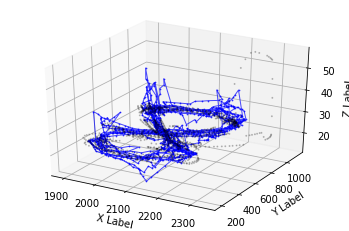

In [308]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(matX[1],matX[0],matX[2], c='black', marker='o', s=1, alpha = 0.2)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label') 

ax.plot(X_hat[1],X_hat[0],X_hat[2], c='blue', marker='o', linewidth = 1, markersize = 0.8, alpha = 0.7)